## **Retail Price Prediction and Optimization Using Regression Trees and Bootstrapping** <br>
By: Ruiz Lorenzo B. Chavez, John Allen C. Caballa, Alyanna Marrielle C. Gammad, Jo-Anne April P. Mejia, Ria Juvica M. Panugan <br>
DATA103 - S11 T2 A.Y. 2022-2023

### **Problem Statement** <br>
It has been known that price optimization has always been constrained as compared in the present times (Simchi-Levi, 2017). Business owners tend to have a hard time deciding the right price to compete amongst its competitors to intrigue its target customers. Moreover, if products are priced wrongfully, it can cause a huge drawback for the business as it would affect customer attraction and have lower leverage for its competitions. However, with the increasing availability of wide data, it has now been accessible and easier to have prices optimized at a right level (Simchi-Levi, 2017).
<br>
<br>
With the advances of technology and machine learning, it has been feasible enough to have price optimization utilized in a bigger sense (Simchi-Levi, 2017). Its relevance lies within the opportunity of businesses to have an optimum price point to increase their profits and possibly customer satisfaction due to products priced enough. Thus, being able to have price optimization allows a competitive advantage in pricing to ultimately reach the business’ goals (Intelligence Node, n.d.). That being said, we aim to develop a retail price prediction and otpimization model by utilizing regression trees and bootstrapping.


### **Data Collection** <br>
For this project, the Brazilian e-commerce public dataset retrieved from [Kaggle](www.kaggle.com/datasets/olistbr/brazilian-ecommerce) will be used. This dataset was created by the Brazilian company, Olist, from actual transactions on their online store. The data was retrieved between 2016-2018, covering a total of 100k unique transactions. Features for this dataset are neatly divided by theme across separate sub datasets, which are linked by its respective foreign keys. Any issues regarding possibly sensitive information have already been dealt with by Olist; all customer names and brands featured in the dataset have been anonymized before then.Overall the information provided in this dataset is rather comprehensive, with a mix of textual, numerical, and geospatial data. 

Below is a table summarizing the features that can be found in the dataset with its equivalent descriptions:


### *olist_products_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| product_id | 
| product_category_name |
| product_name_length |
| product_description_length |
| product_description_length |
| prodduct_photos_qty |
| product_length_cm |
| product_height_cm |
| product_width_cm |


*description of each feature taken from Kaggle*

### *product_trans_df*

| column | type | dtype | description |
|--------|-------|----|----------|
| product_category_name | 
| product_category_name_english |


*description of each feature taken from Kaggle*

### *olist_orders_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| order_item_id |
| product_id |
| shipping_limit_date |
| price |


*description of each feature taken from Kaggle*

### *olist_order_items_dataset*

| column | type | dtype | description |
|--------|-------|----|----------|
| order_id | 
| order_item_id |
| product_id |
| seller_id |
| shipping_limit_date |
| price |
| fright_value |


*description of each feature taken from Kaggle*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from time import strftime

## Data Preprocessing

### Loading the dataset: Brazilian E-commerce Public Dataset by Olist

In [2]:
#  dataset on product info
products_df = pd.read_csv("data/olist_products_dataset.csv")                    #  shows product information as advertised on the site
product_trans_df = pd.read_csv("data/product_category_name_translation.csv")    #  shows product name translations

#  datasets on orders info 
order_only_df = pd.read_csv("data/olist_orders_dataset.csv",                    #  * MAIN DATASET: shows order transactions 
                            parse_dates=["order_purchase_timestamp",
                                         "order_approved_at",                
                                         "order_delivered_carrier_date",     
                                         "order_delivered_customer_date",    
                                         "order_estimated_delivery_date"])                                   
order_items_df = pd.read_csv("data/olist_order_items_dataset.csv",              #  shows order/product price + shipping fee
                             parse_dates=["shipping_limit_date"])              
order_payments_df = pd.read_csv("data/olist_order_payments_dataset.csv")        #  shows order payment total + method
order_reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv",          #  shows order reviews (numerical + text)
                               parse_dates=["review_creation_date",
                                            "review_answer_timestamp"])          

#  datasets on customer and seller
customer_df = pd.read_csv("data/olist_customers_dataset.csv")                   #  shows customer info (location)
seller_df = pd.read_csv("data/olist_sellers_dataset.csv")                       #  shows sellenr info (location)

#  dataset on geolocation/coordinates of cities/states in Brazil
geolocation_df = pd.read_csv("data/olist_geolocation_dataset.csv")              #  shows coordinates of locations in Brazil (customer & seller position)

![data schema of Olist dataset](notebook_images/data_schema.png)

In [3]:
df_dict = {
    "products_df": products_df,
    "product_trans_df": product_trans_df,
    "order_only_df": order_only_df,
    "order_items_df": order_items_df,
    "order_payments_df": order_payments_df,
    "order_reviews_df": order_reviews_df,
    "customer_df": customer_df,
    "seller_df": seller_df,
    "geolocation_df": geolocation_df,
    }

for df in df_dict:
    print(f"\n{df}")
    display(df_dict[df].head())


products_df


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0



product_trans_df


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor



order_only_df


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26



order_items_df


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



order_payments_df


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45



order_reviews_df


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53



customer_df


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



seller_df


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



geolocation_df


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


### Diagnosing the data

#### Shape of each dataset

In [4]:
for df in df_dict:
    row_num, col_num = df_dict[df].shape
    print(f"{df} has {row_num:,} rows and {col_num:,} columns")

products_df has 32,951 rows and 9 columns
product_trans_df has 71 rows and 2 columns
order_only_df has 99,441 rows and 8 columns
order_items_df has 112,650 rows and 7 columns
order_payments_df has 103,886 rows and 5 columns
order_reviews_df has 99,224 rows and 7 columns
customer_df has 99,441 rows and 5 columns
seller_df has 3,095 rows and 4 columns
geolocation_df has 1,000,163 rows and 5 columns


#### Correcting typos in the column of products_df

In [5]:
#  correcting column name 
products_df = products_df.rename(columns={"product_name_lenght": "product_name_length",
                                          "product_description_lenght": "product_description_length"})

#### Merging relevant datasets 

In [6]:
items_shape, transaction_shape, reviews_shape = order_items_df.shape, order_only_df.shape, order_reviews_df.shape
print(f"Merging order_items_df {items_shape}, order_only_df {transaction_shape}, and order_reviews_df {reviews_shape}")

#  left join order_items & order_only to get the most entries
transactions_df = (order_items_df
                   .merge(order_only_df,
                          how="inner",
                          on="order_id")
                   .merge(order_reviews_df,
                          how="inner",
                          on="order_id")
                   )

print(f"transactions_df has {transactions_df.shape}")

Merging order_items_df (112650, 7), order_only_df (99441, 8), and order_reviews_df (99224, 7)
transactions_df has (112372, 20)


In [7]:
products_shape, translation_shape = products_df.shape, product_trans_df.shape
print(f"Merging order_items_df {products_shape} and order_only_df {translation_shape}")

products_df = products_df.merge(product_trans_df,
                                on="product_category_name",
                                how="inner")

products_df = products_df.drop(columns=["product_category_name"])

print(f"products_df has {products_df.shape}")

Merging order_items_df (32951, 9) and order_only_df (71, 2)
products_df has (32328, 9)


In [8]:
transaction_shape, products_shape = transactions_df.shape, products_df.shape
print(f"Merging transaction_df {transaction_shape} and products_df {products_shape}")

transactions_df = transactions_df.merge(products_df,
                                        on="product_id",
                                        how="inner")

print(f"transactions_df has {transactions_df.shape}")
transactions_df.head()

Merging transaction_df (112372, 20) and products_df (32328, 9)
transactions_df has (110750, 28)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-21,2017-09-22 10:57:03,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,2017-07-14,2017-07-17 12:50:07,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,...,2018-06-05,2018-06-06 21:41:12,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,...,2017-08-10,2017-08-13 03:35:17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,...,2017-08-25,2017-08-28 00:51:18,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


#### Checking for null values in the dataset

,null_count,percent_null,dytpes
order_id,0,0.000000,object
order_item_id,0,0.000000,int64
product_id,0,0.000000,object
seller_id,0,0.000000,object
shipping_limit_date,0,0.000000,datetime64[ns]
price,0,0.000000,float64
freight_value,0,0.000000,float64
customer_id,0,0.000000,object
order_status,0,0.000000,object
order_purchase_timestamp,0,0.000000,datetime64[ns]


<AxesSubplot:>

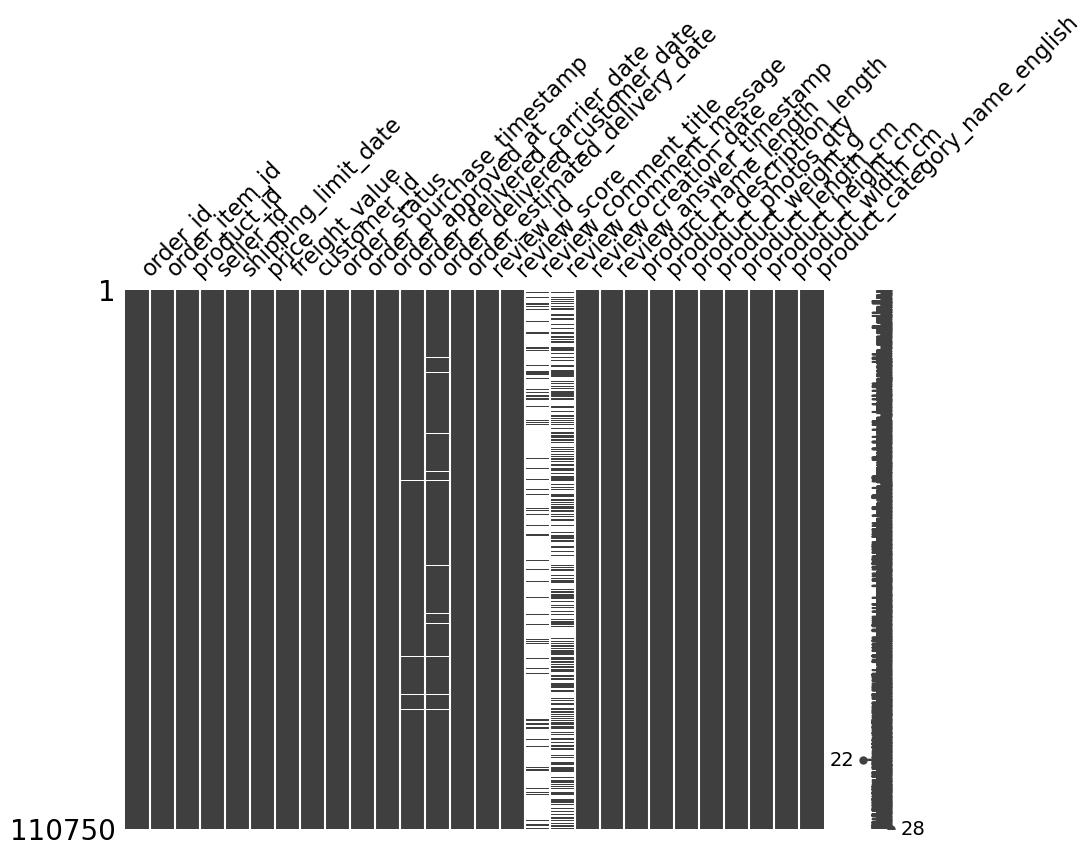

In [9]:
def column_eval(df) -> pd.DataFrame:
    null_count = df.isna().sum()
    total_rows = df.shape[0]
    percent_null = (null_count / total_rows) * 100
    column_dtypes = df.dtypes
    
    null_dataframe = pd.DataFrame(data={"null_count": null_count,
                                        "percent_null": percent_null,
                                        "dytpes": column_dtypes},
                                  index=df.columns)
    return null_dataframe

transactions_eval = column_eval(transactions_df)
display(transactions_eval)
display(msno.matrix(transactions_df, 
                    figsize=(10,7))
        )

##### Dealing with null values

<AxesSubplot:>

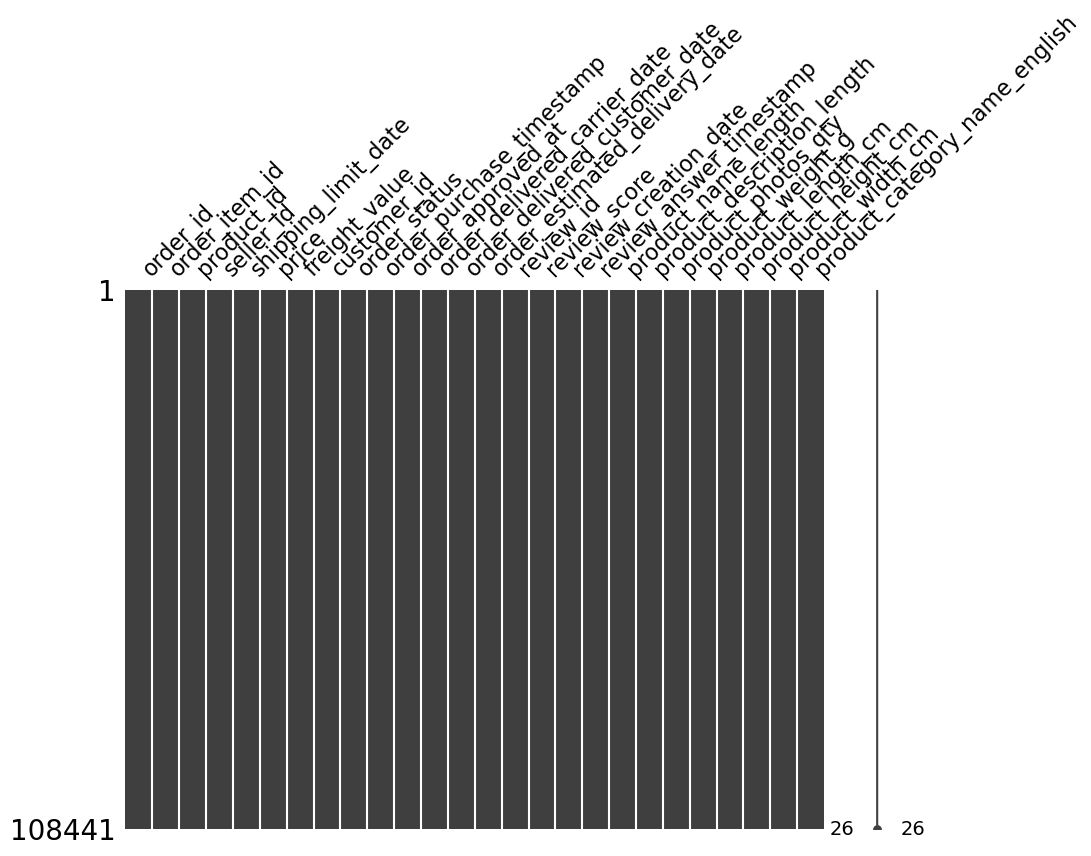

In [10]:
#  remove columns with more than 50% empty values
mostly_null_columns = transactions_eval.query("percent_null > 50").index
transactions_df = transactions_df.drop(columns=mostly_null_columns)

#  remove rows with null values
transactions_df = transactions_df.dropna(axis=0)

display(msno.matrix(transactions_df, 
                    figsize=(10,7) 
                   )
        )

#### Checking for duplicates in the dataset

In [11]:
duplicated = transactions_df.duplicated(subset=["order_id",
                                               "order_item_id",
                                               "product_id",
                                               "customer_id",
                                               "price"
                                               ])

duplicates = transactions_df[duplicated]

sample_duplicate = duplicates.sample().iloc[0,7]

print(f"There are {duplicates.shape[0]} duplicated values")

#  sample duplicated values from this specific customer
print(f"Sample of duplicated transactions from the same customer (customer ID: {sample_duplicate})")
transactions_df.query("customer_id == @sample_duplicate")

There are 635 duplicated values
Sample of duplicated transactions from the same customer (customer ID: 1f4c47d2259bd9e65d581d268b02d0a6)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
39675,097abce97e431993434adabc1aaec4e4,1,54b755678728b84472c2b654ac4de777,a3dd39f583bc80bd8c5901c95878921e,2017-10-15 23:28:20,52.0,21.16,1f4c47d2259bd9e65d581d268b02d0a6,delivered,2017-10-08 22:13:39,...,2017-10-17,2017-10-18 02:13:33,26.0,2427.0,1.0,200.0,20.0,12.0,15.0,food_drink
39676,097abce97e431993434adabc1aaec4e4,1,54b755678728b84472c2b654ac4de777,a3dd39f583bc80bd8c5901c95878921e,2017-10-15 23:28:20,52.0,21.16,1f4c47d2259bd9e65d581d268b02d0a6,delivered,2017-10-08 22:13:39,...,2017-10-12,2017-10-12 16:47:14,26.0,2427.0,1.0,200.0,20.0,12.0,15.0,food_drink


##### Dealing with duplicate values

In [12]:
#  removing duplicated values
transactions_df = transactions_df.drop_duplicates(subset=["order_id",
                                                          "order_item_id",
                                                          "product_id",
                                                          "customer_id",
                                                          "price"
                                                          ])

print(f"There are now {transactions_df.shape[0]} rows, which is {duplicates.shape[0]} less than before")

There are now 107806 rows, which is 635 less than before


#### Checking categorical values

In [13]:
categorical_cols = transactions_df.loc[:, transactions_df.dtypes == "object"]
categorical_cols.nunique()

order_id                         94472
product_id                       31474
seller_id                         2907
customer_id                      94472
order_status                         2
review_id                        94043
product_category_name_english       71
dtype: int64

In [14]:
filtered_categ_cols = categorical_cols.loc[:, categorical_cols.nunique() < 100]

for col in filtered_categ_cols:
    print(f"Unique values in {col}")
    display(transactions_df[col].unique())

Unique values in order_status


array(['delivered', 'canceled'], dtype=object)

Unique values in product_category_name_english


array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto',
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'cine_p

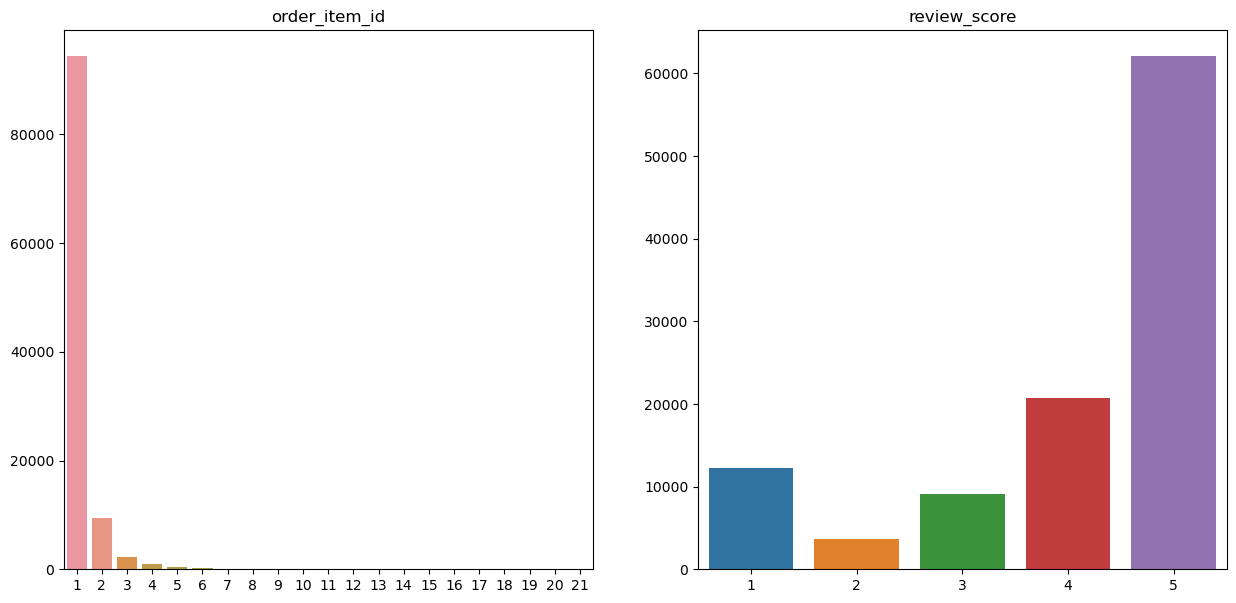

In [15]:
int_cols = transactions_df.loc[:, transactions_df.dtypes == "int64"]

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(int_cols):
    plt.subplot(1,2,i+1, label=col)
    int_frequency = transactions_df[col].value_counts()
    sns.barplot(x=int_frequency.index, y=int_frequency.values)
    plt.title(col)

#### Checking numerical columns (outlier detection)

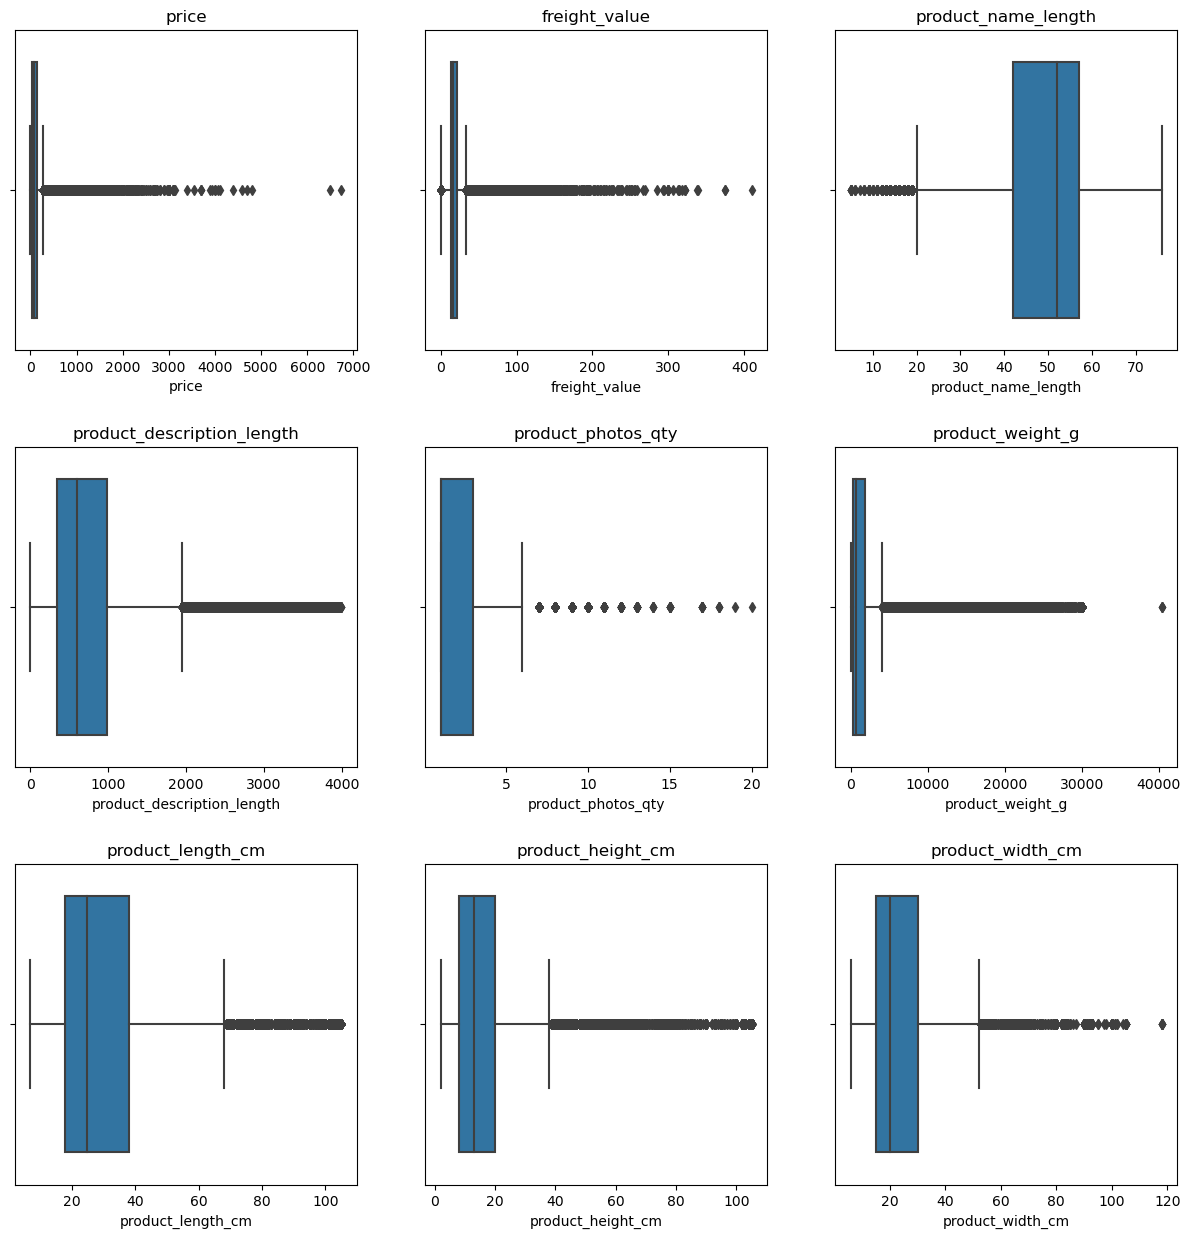

In [16]:
float_cols = transactions_df.loc[:, transactions_df.dtypes == "float64"]

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(float_cols):
    plt.subplot(3,3,i+1, label=col)
    sns.boxplot(data=transactions_df, x=col)
    plt.title(col)

#### Checking datetime columns

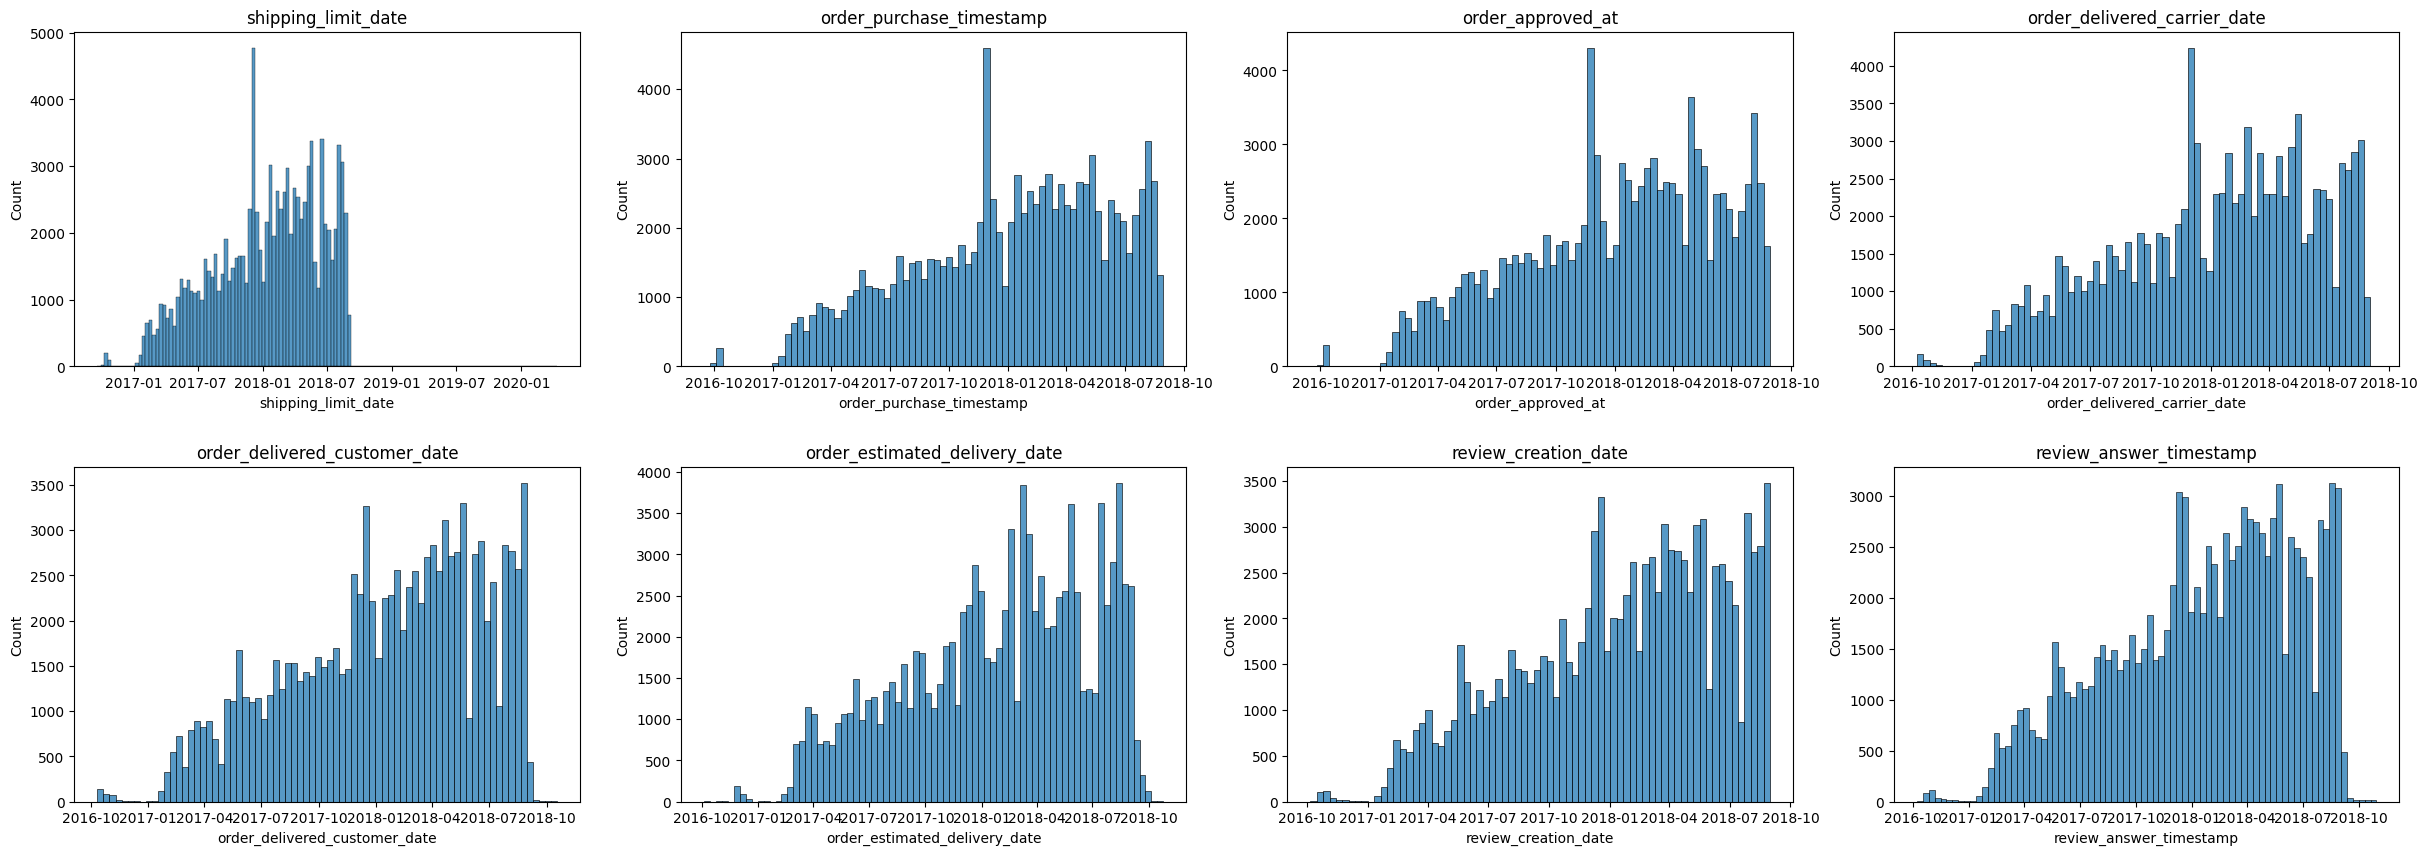

In [ ]:
datetime_cols = transactions_df.loc[:, transactions_df.dtypes == "datetime64[ns]"]

fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(datetime_cols):
    plt.subplot(2,4,i+1, label=col)
    sns.histplot(data=transactions_df, x=col)
    plt.title(col)

### Feature engineering

#### Feature selection

In [17]:
relevant_features = ['product_id',
                     'price',
                     'order_purchase_timestamp',
                     'review_score',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm',
                     'product_category_name_english',
                     ]

Why are the others deemed irrelevant? yung mga ibang dates can be useful when optimizing price for freight but that's not what we're doing naman

In [18]:
main_df = transactions_df.copy()
main_df = main_df[relevant_features]
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
9390,53759a2ecddad2bb87a079a1f1519f73,59.90,2017-10-06 23:13:21,3,1500.0,30.0,22.0,30.0,garden_tools
66838,29b85c2f1ec5f4d02b03737a8fd3698b,198.00,2017-06-03 20:23:59,5,850.0,16.0,19.0,15.0,furniture_decor
50181,68a058d125ba1544e726898f0b8c0523,139.99,2017-04-02 18:22:23,5,10475.0,52.0,51.0,17.0,office_furniture
49602,38c56c5c5b16958d95bf8254498ad555,799.00,2017-11-01 23:33:26,5,500.0,16.0,11.0,11.0,watches_gifts
40259,2ffdf10e724b958c0f7ea69e97d32f64,224.90,2018-02-20 18:03:43,1,263.0,17.0,12.0,13.0,watches_gifts


#### Feature generation

In [19]:
#  TODO: specify Brazilian holidays
# brazilian_holidays = [""]

In [20]:
main_df["day_of_week"] = main_df["order_purchase_timestamp"].dt.day_of_week
main_df["is_weekday"] = main_df["day_of_week"] < 5
main_df["month"] = main_df["order_purchase_timestamp"].dt.month
main_df["year"] = main_df["order_purchase_timestamp"].dt.year
main_df["hour"] = main_df["order_purchase_timestamp"].dt.hour
main_df["date_purchased"] = pd.to_datetime(main_df["order_purchase_timestamp"].dt.date)
# ! feature coming soon: is_holiday
# main_df["is_holiday"] = main_df["date_purchased"].isin()
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased
36540,566a4f2c4385f36d15c00dfcaae132d1,21.90,2017-12-28 18:48:01,5,150.0,25.0,7.0,16.0,electronics,3,True,12,2017,18,2017-12-28
90118,faa36d27544b2b05c79f3d8c801d5dbd,35.90,2017-09-10 12:54:36,3,600.0,43.0,16.0,27.0,perfumery,6,False,9,2017,12,2017-09-10
12974,f77dd338d9f75229a09cbb9a18fd0c9a,27.50,2018-04-30 10:59:11,5,400.0,20.0,20.0,20.0,bed_bath_table,0,True,4,2018,10,2018-04-30
100361,2e7fb5448f9e5ef6939e305aa9b8d999,12.97,2017-08-20 16:19:21,5,150.0,18.0,6.0,11.0,telephony,6,False,8,2017,16,2017-08-20
40117,a39cc58c1b5926b6f9f378daa89f1315,150.00,2018-08-05 18:52:58,1,3800.0,30.0,35.0,30.0,home_construction,6,False,8,2018,18,2018-08-05


In [21]:
main_df["product_volume_cm3"] = main_df["product_length_cm"] * main_df["product_width_cm"] * main_df["product_height_cm"]
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
83016,bf8193d8e1127957f3b82527c6d44c01,49.9,2017-07-24 20:10:01,3,500.0,25.0,7.0,20.0,luggage_accessories,0,True,7,2017,20,2017-07-24,3500.0
11693,422879e10f46682990de24d770e7f83d,49.0,2017-11-24 12:33:11,5,1550.0,30.0,22.0,30.0,garden_tools,4,True,11,2017,12,2017-11-24,19800.0
33725,06f0e85c7892d5df893f332706340af1,179.0,2017-11-28 16:48:13,4,9850.0,30.0,19.0,60.0,stationery,1,True,11,2017,16,2017-11-28,34200.0
58245,eac9f4e3a6148ef63f16aaec0cd9731f,19.9,2017-09-07 15:21:22,5,700.0,16.0,22.0,20.0,bed_bath_table,3,True,9,2017,15,2017-09-07,7040.0
1113,5a419dbf24a8c9718fe522b81c69f61a,48.9,2017-09-11 17:39:33,5,1800.0,34.0,5.0,34.0,cool_stuff,0,True,9,2017,17,2017-09-11,5780.0


### Final diagnosis of main_df

In [22]:
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
34771,25da7af0ae86de644e6410fec1d599d1,659.00,2018-02-21 08:52:11,5,26000.0,60.0,60.0,17.0,auto,2,True,2,2018,8,2018-02-21,61200.0
58755,2481a472d98c582b46bc2dfeae6f539f,59.55,2017-11-24 02:30:24,5,950.0,31.0,11.0,26.0,furniture_decor,4,True,11,2017,2,2017-11-24,8866.0
40846,68d9c8a95d2b7cb57efe9e1e929bdd6a,39.99,2017-02-28 22:12:55,4,100.0,16.0,2.0,11.0,fixed_telephony,1,True,2,2017,22,2017-02-28,352.0
95592,4b2e8d0baa7e0e7483c8bfe1dc33e406,259.90,2017-06-19 19:50:44,4,300.0,16.0,11.0,20.0,watches_gifts,0,True,6,2017,19,2017-06-19,3520.0
2161,d54c5b81fc2b38707588dd4eddc7c594,249.00,2018-05-24 16:17:48,5,7850.0,52.0,18.0,35.0,furniture_decor,3,True,5,2018,16,2018-05-24,32760.0


In [23]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107806 entries, 0 to 110749
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     107806 non-null  object        
 1   price                          107806 non-null  float64       
 2   order_purchase_timestamp       107806 non-null  datetime64[ns]
 3   review_score                   107806 non-null  int64         
 4   product_weight_g               107806 non-null  float64       
 5   product_length_cm              107806 non-null  float64       
 6   product_height_cm              107806 non-null  float64       
 7   product_width_cm               107806 non-null  float64       
 8   product_category_name_english  107806 non-null  object        
 9   day_of_week                    107806 non-null  int64         
 10  is_weekday                     107806 non-null  bool          
 11  

In [24]:
main_row, main_col = main_df.shape

print(f"main_df has a total of {main_row} entries and {main_col} features.")

main_df has a total of 107806 entries and 16 features.


## Exploratory Data Analysis (EDA)

### Sampling for our dataset

In [25]:
sampled_df = main_df.copy()
sampled_df = sampled_df.sample(frac=.05, random_state=25)
sampled_df

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
69574,113f80f12c8892f0c59206f70b862b40,19.90,2018-07-14 09:47:09,5,250.0,16.0,10.0,16.0,bed_bath_table,5,False,7,2018,9,2018-07-14,2560.0
109365,367f4a5ae70f2e8de8d9eb1c13f280b1,9.00,2017-05-26 15:53:43,5,1950.0,20.0,6.0,20.0,sports_leisure,4,True,5,2017,15,2017-05-26,2400.0
10626,19c91ef95d509ea33eda93495c4d3481,122.99,2018-08-07 20:27:57,4,700.0,25.0,12.0,19.0,health_beauty,1,True,8,2018,20,2018-08-07,5700.0
79627,6cbe4bd19efc4606eb2a9448a47e232e,38.90,2018-02-15 10:03:54,4,300.0,30.0,20.0,20.0,consoles_games,3,True,2,2018,10,2018-02-15,12000.0
44343,704ef63ad0ac345842ea734060a83db2,74.90,2018-01-12 18:43:34,4,850.0,38.0,10.0,38.0,bed_bath_table,4,True,1,2018,18,2018-01-12,14440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61402,e840aad8112818661548fda5d12653f2,75.27,2017-11-21 14:55:38,1,1400.0,36.0,8.0,29.0,bed_bath_table,1,True,11,2017,14,2017-11-21,8352.0
49671,77ff4f618d7c0d6b442ecdf5f02f6a74,149.90,2018-06-10 15:10:13,1,2150.0,60.0,15.0,15.0,sports_leisure,6,False,6,2018,15,2018-06-10,13500.0
61688,0df80257de6a3154415598a80718fb81,9.00,2018-01-13 11:25:16,4,100.0,25.0,7.0,16.0,electronics,5,False,1,2018,11,2018-01-13,2800.0
911,368c6c730842d78016ad823897a372db,59.90,2017-10-29 23:07:30,5,1650.0,30.0,22.0,30.0,garden_tools,6,False,10,2017,23,2017-10-29,19800.0


### Checking out distribution of features

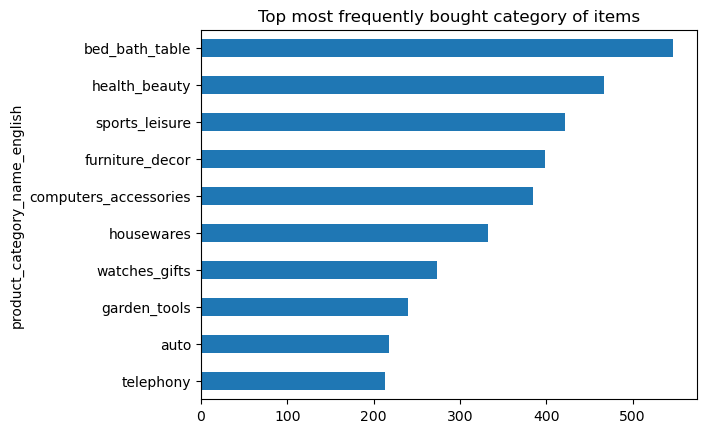

In [26]:
(sampled_df
 .groupby("product_category_name_english")["product_id"]
 .count()
 .sort_values(ascending=False)
 .head(10)
 .plot
 .barh(title="Top most frequently bought category of items")
 .invert_yaxis()
 )

<AxesSubplot:title={'center':'Purchase made on a weekday?'}>

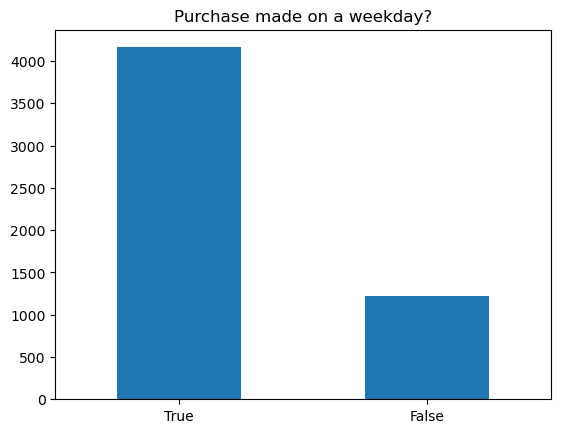

In [27]:
(sampled_df
 .is_weekday
 .value_counts()
 .plot
 .bar(rot=0,
      title="Purchase made on a weekday?")
 )

<AxesSubplot:ylabel='Frequency'>

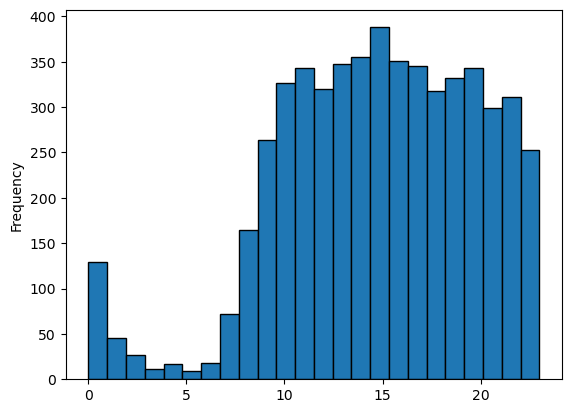

In [28]:
sampled_df.hour.plot.hist(bins=24,edgecolor="black")

Text(0.5, 0, '[0] Monday - [6] Sunday')

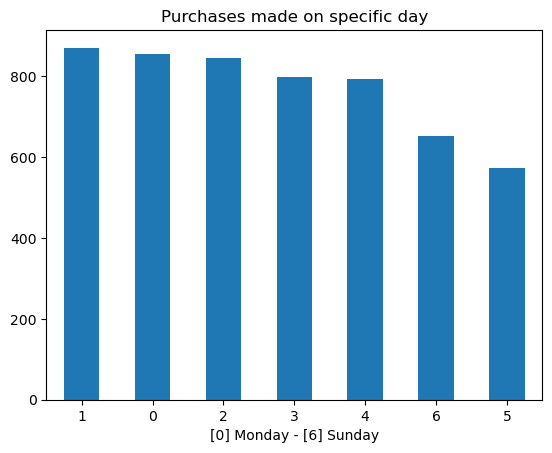

In [29]:
(sampled_df
 .day_of_week.
 value_counts()
 .plot
 .bar(rot=0,
      title="Purchases made on specific day"
      )
 )
plt.xlabel("[0] Monday - [6] Sunday")

<AxesSubplot:title={'center':'Distribution of purchases made in each month'}>

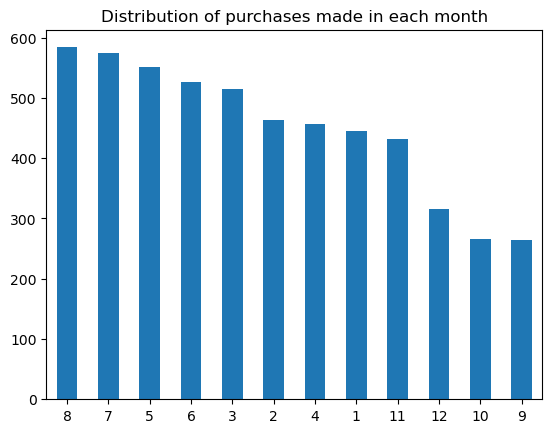

In [30]:
(sampled_df
 .month
 .value_counts()
 .plot
 .bar(rot=0,
      title="Distribution of purchases made in each month"))

<AxesSubplot:title={'center':'Distribution of purchases made in each year'}>

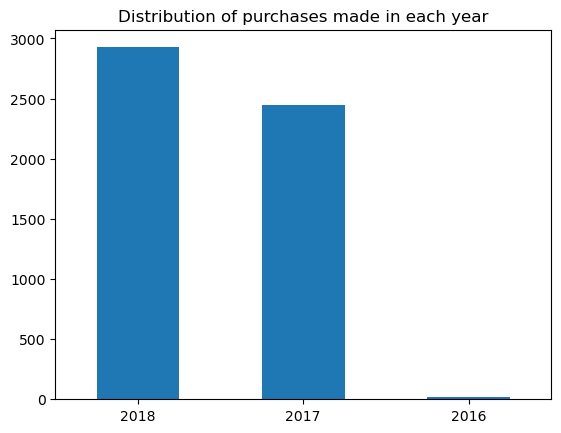

In [31]:
(sampled_df
 .year
 .value_counts()
 .plot
 .bar(rot=0,
       title="Distribution of purchases made in each year"))

<AxesSubplot:title={'center':'Distribution of review scores'}>

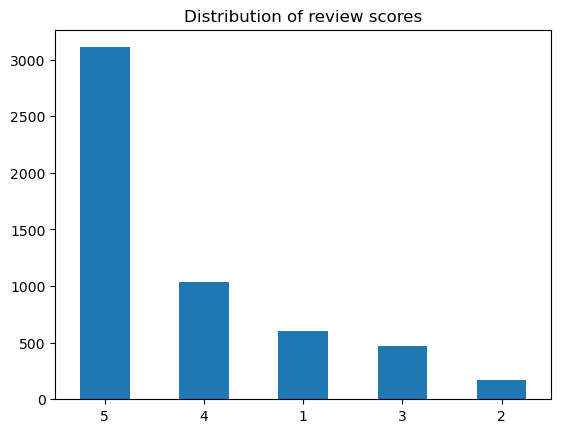

In [32]:
(sampled_df
 .review_score
 .value_counts()
 .plot
 .bar(rot=0,
      title="Distribution of review scores"))

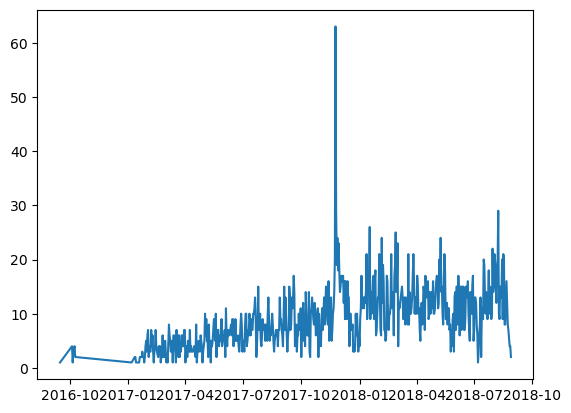

In [33]:
purchase_freq_date = sampled_df.date_purchased.value_counts().sort_index()
plt.plot(purchase_freq_date.index, purchase_freq_date.values)

<AxesSubplot:xlabel='date_purchased'>

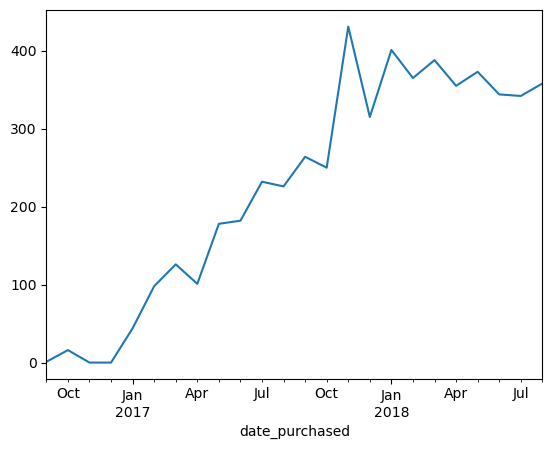

In [34]:
sampled_df.groupby(pd.Grouper(key="date_purchased", freq="M"))["product_id"].count().plot.line()

## Decision Trees

In [35]:
main_df

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,hour,date_purchased,product_volume_cm3
0,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-09-13 08:59:02,5,650.0,28.0,9.0,14.0,cool_stuff,2,True,9,2017,8,2017-09-13,3528.0
1,4244733e06e7ecb4970a6e2683c13e61,55.9,2017-06-28 11:52:20,5,650.0,28.0,9.0,14.0,cool_stuff,2,True,6,2017,11,2017-06-28,3528.0
2,4244733e06e7ecb4970a6e2683c13e61,64.9,2018-05-18 10:25:53,4,650.0,28.0,9.0,14.0,cool_stuff,4,True,5,2018,10,2018-05-18,3528.0
3,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-08-01 18:38:42,5,650.0,28.0,9.0,14.0,cool_stuff,1,True,8,2017,18,2017-08-01,3528.0
4,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-08-10 21:48:40,5,650.0,28.0,9.0,14.0,cool_stuff,3,True,8,2017,21,2017-08-10,3528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110745,4cc4d02efc8f249c13355147fb44e34d,129.9,2018-07-13 20:04:05,5,6700.0,35.0,12.0,22.0,garden_tools,4,True,7,2018,20,2018-07-13,9240.0
110746,b10ecf8e33aaaea419a9fa860ea80fb5,99.0,2018-08-18 10:00:59,4,2300.0,37.0,30.0,20.0,furniture_decor,5,False,8,2018,10,2018-08-18,22200.0
110747,dd469c03ad67e201bc2179ef077dcd48,736.0,2017-06-01 16:53:03,5,400.0,19.0,9.0,15.0,watches_gifts,3,True,6,2017,16,2017-06-01,2565.0
110748,bbe7651fef80287a816ead73f065fc4b,229.9,2017-12-18 16:33:07,4,2700.0,60.0,15.0,15.0,sports_leisure,0,True,12,2017,16,2017-12-18,13500.0


## Creating dummy variables

In [37]:
main_dummy_df=pd.get_dummies(main_df,columns=['product_category_name_english', 'is_weekday'])
main_dummy_df

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,day_of_week,month,...,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts,is_weekday_False,is_weekday_True
0,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-09-13 08:59:02,5,650.0,28.0,9.0,14.0,2,9,...,0,0,0,0,0,0,0,0,0,1
1,4244733e06e7ecb4970a6e2683c13e61,55.9,2017-06-28 11:52:20,5,650.0,28.0,9.0,14.0,2,6,...,0,0,0,0,0,0,0,0,0,1
2,4244733e06e7ecb4970a6e2683c13e61,64.9,2018-05-18 10:25:53,4,650.0,28.0,9.0,14.0,4,5,...,0,0,0,0,0,0,0,0,0,1
3,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-08-01 18:38:42,5,650.0,28.0,9.0,14.0,1,8,...,0,0,0,0,0,0,0,0,0,1
4,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-08-10 21:48:40,5,650.0,28.0,9.0,14.0,3,8,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110745,4cc4d02efc8f249c13355147fb44e34d,129.9,2018-07-13 20:04:05,5,6700.0,35.0,12.0,22.0,4,7,...,0,0,0,0,0,0,0,0,0,1
110746,b10ecf8e33aaaea419a9fa860ea80fb5,99.0,2018-08-18 10:00:59,4,2300.0,37.0,30.0,20.0,5,8,...,0,0,0,0,0,0,0,0,1,0
110747,dd469c03ad67e201bc2179ef077dcd48,736.0,2017-06-01 16:53:03,5,400.0,19.0,9.0,15.0,3,6,...,0,0,0,0,0,0,0,1,0,1
110748,bbe7651fef80287a816ead73f065fc4b,229.9,2017-12-18 16:33:07,4,2700.0,60.0,15.0,15.0,0,12,...,0,0,1,0,0,0,0,0,0,1
